# Libraries & Analysis Set Up

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Data Preparation and Wrangling

### Alcohol Policies

In [245]:
df_alcohol = pd.read_csv("COVID-19 Alcohol.csv")
df_alcohol = df_alcohol[['State Abbreviation','Alcohol/Liquor Stores Open', 'Keep Firearms Sellers Open']].copy()

### Face Masks Policies

In [246]:
df_face_mask = pd.read_csv("COVID-19 Face Masks.csv")

df_face_mask['start_date'] = pd.to_datetime(df_face_mask['Public face mask mandate start'], errors='coerce')
df_face_mask['end_date'] = pd.to_datetime(df_face_mask['Face mask mandate end'], errors='coerce')

latest_date = df_face_mask['end_date'].max()

# Calculate the duration of the face mask mandate
def get_duration(row):
    start = row['start_date']
    end = row['end_date']

    # If no start date, duration is 0
    if pd.isna(start):
        return 0
    # If start exists but no end date, assume it lasted until the latest date
    if pd.isna(end):
        end = latest_date
        
    return (end - start).days

# Generate a socring system for pro mask face policies
def calculate_mask_score(row):
    score = 0
    
    if str(row['Public face mask mandate start']) != '0':
        score += 1
    if row['Face mask mandate enforced by fines'] == 1:
        score += 1
    if row['Face mask mandate enforced by criminal charge/citation'] == 1:
        score += 1
    if str(row['Business face mask mandate start']) != '0':
        score += 1
        
    if row['No legal enforcement of face mask mandate'] == 1:
        score -= 1
    if str(row['Banned school face mask mandates']) != '0':
        score -= 1
    if str(row['Banned other local face mask mandates']) != '0':
        score -= 1
        
    return score


df_face_mask['Face_Mask_Mandate_Duration_Days'] = df_face_mask.apply(get_duration, axis=1)
df_face_mask['Pro_Mask_Score'] = df_face_mask.apply(calculate_mask_score, axis=1)

### Stay At Home Policies

In [247]:
df_stay_home = pd.read_csv("COVID-19 Stay At Home.csv")

df_stay_home['start_date'] = pd.to_datetime(df_stay_home['Stay at home/shelter in place'], errors='coerce')
df_stay_home['end_date'] = pd.to_datetime(df_stay_home['End stay at home/shelter in place '], errors='coerce')

earliest_date = df_stay_home['start_date'].min()
latest_date = df_stay_home['end_date'].max()

df_stay_home['Stay_at_Home_Duration_Days'] = df_stay_home.apply(get_duration, axis=1)

df_stay_home = df_stay_home[
    ['State Abbreviation','Stay at home/shelter in place','End stay at home/shelter in place ',
      'start_date', 'end_date', 'Stay_at_Home_Duration_Days']
      ].copy()

### Food And Beverage sales

In [300]:
df_sales = pd.read_csv("Food-&-Beverage-stores.csv")

# rename to readable state abbreviations
df_sales.rename(columns=lambda x: x[4:6] if x.startswith('MSRS') else x, inplace=True)

# Categorize and cluster the periods into covid labels
df_sales['observation_date'] = pd.to_datetime(df_sales['observation_date'], errors='coerce')

def categorize_period(date):
    if date < pd.to_datetime('2020-03-01'): return 'Pre-COVID'
    elif date < pd.to_datetime('2021-01-01'): return 'Panic Phase'
    elif date < pd.to_datetime('2022-01-01'): return 'Adjustment Phase'
    else: return 'Post-COVID'

df_sales['Period'] = df_sales['observation_date'].apply(categorize_period)

# Average the sales accross the periods
df_final = df_sales.groupby('Period').mean(numeric_only=True).T.reset_index()

df_final.rename(columns={'index': 'State Abbreviation'}, inplace=True)

cols_order = ['State Abbreviation', 'Pre-COVID', 'Panic Phase', 'Adjustment Phase', 'Post-COVID']
df_sales_final = df_final[cols_order]

# COIVD-19 Impact on sales

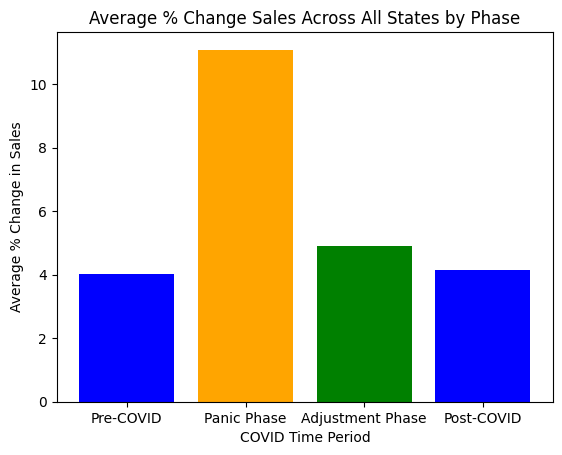

In [301]:
df_sales_national = df_sales_final[
    ['Pre-COVID','Panic Phase', 'Adjustment Phase', 'Post-COVID']
    ].mean()

plt.bar(df_sales_national.index, df_sales_national.values, color=['blue', 'orange', 'green'])

plt.xlabel('COVID Time Period')
plt.ylabel('Average % Change in Sales')
plt.title('Average % Change Sales Across All States by Phase')

# Show the plot
plt.show()



Sales during COVID (in the panic phase) spiked significantly to more than %10 compared to the stability in other periods, which is likely due to panic buying and stockpiling of goods as people prepared for lockdowns and uncertainty. The Adjustment Phase was more than the other phases slightly as the likely the panic in the population almost, but not entirely, disappered.

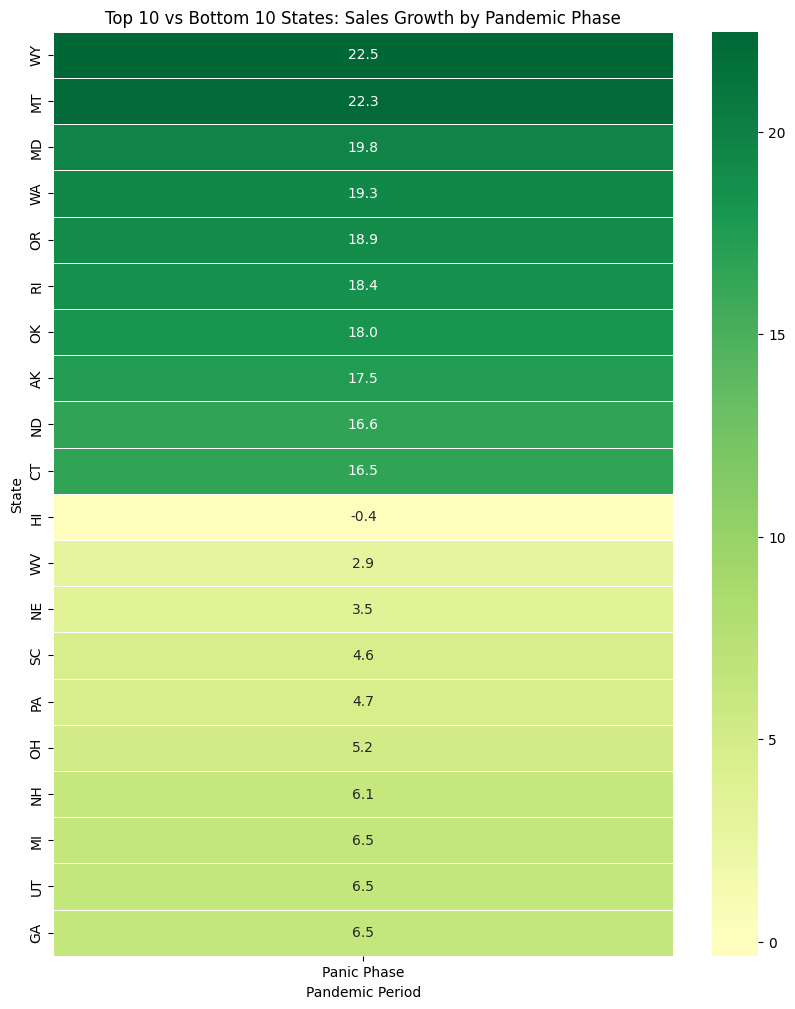

In [302]:
top_states_covid = df_sales_final[['State Abbreviation','Panic Phase']
               ].sort_values(by = 'Panic Phase',ascending=False)[:10]

lowest_states_covid = df_sales_final[['State Abbreviation','Panic Phase']
               ].sort_values(by = 'Panic Phase')[:10]

heatmap_filtered = pd.concat([top_states_covid, lowest_states_covid])

plt.figure(figsize=(10, 12)) 
sns.heatmap(heatmap_filtered.set_index('State Abbreviation'), annot=True, cmap='RdYlGn', center=0, fmt=".1f", linewidths=.5)
plt.title('Top 10 vs Bottom 10 States: Sales Growth by Pandemic Phase')
plt.xlabel('Pandemic Period')
plt.ylabel('State')

plt.savefig('US_Sales_Heatmap_TopBottom10.png')

The graphs show that most states experienced higher sales percentage changes during the pandemic's "Panic Phase" compared to the average sales change of around 4% observed in other periods. The top 10 states, led by Wyoming (22.5%) Montana (22.3%) Maryland (%19.8) and Washington (19.3%), saw significantly higher sales growth, while the bottom 10 states, including Hawaii (-0.4%) and West Virginia (2.9%), had modest or even negative changes. Notably, only a few states, like Hawaii, fell below the average, highlighting that the pandemic phase generally drove increased sales across the majority of states.

# Policy Correlation and Impact On Sales

In [303]:
df_policies = pd.merge(df_face_mask[['State Abbreviation','Face_Mask_Mandate_Duration_Days','Pro_Mask_Score']], 
                       df_stay_home[['State Abbreviation','Stay_at_Home_Duration_Days']], 
                       on='State Abbreviation', 
                       how='outer')

df_policies = pd.merge(df_policies, 
                       df_alcohol, 
                       on='State Abbreviation', 
                       how='outer')
df_policies.head()

,State Abbreviation,Face_Mask_Mandate_Duration_Days,Pro_Mask_Score,Stay_at_Home_Duration_Days,Alcohol/Liquor Stores Open,Keep Firearms Sellers Open
0,AK,28,4,27,1,1
1,AL,267,1,26,1,1
2,AR,253,2,0,1,1
3,AZ,0,-2,46,1,1
4,CA,607,1,312,1,0


In [304]:
# Combining sales with policies
df = df_policies.merge(df_sales_final[['State Abbreviation','Adjustment Phase']], on = 'State Abbreviation')
df.dropna(inplace = True)

# Defining the Independent and dependent features for the multi linear regression model
X = df[
    ['Face_Mask_Mandate_Duration_Days','Pro_Mask_Score','Stay_at_Home_Duration_Days',
     'Alcohol/Liquor Stores Open','Keep Firearms Sellers Open']
     ]
Y = df['Adjustment Phase']

# Add y intercept
X = sm.add_constant(X)

# Run the model
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Adjustment Phase   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.3127
Date:                Thu, 08 Jan 2026   Prob (F-statistic):              0.903
Time:                        14:19:44   Log-Likelihood:                -169.85
No. Observations:                  49   AIC:                             351.7
Df Residuals:                      43   BIC:                             363.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

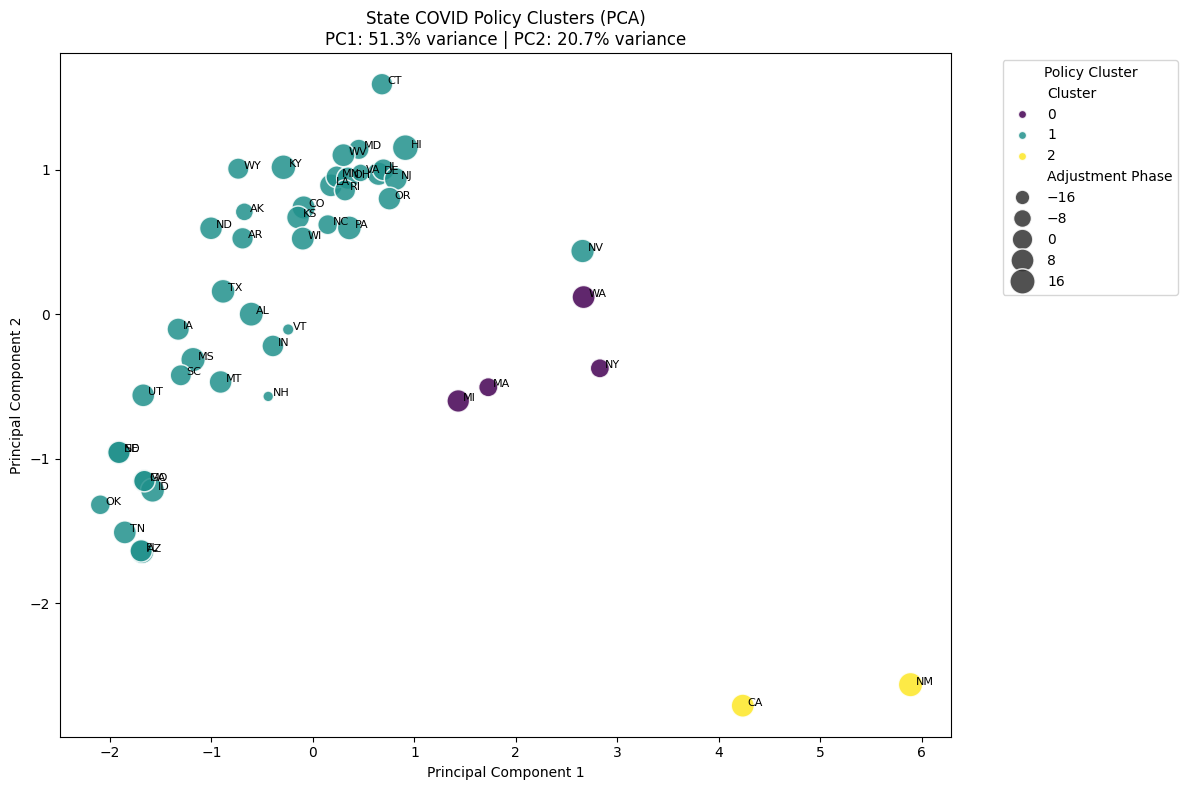

In [305]:
# Define the variables
features = ['Face_Mask_Mandate_Duration_Days', 'Pro_Mask_Score', 
            'Stay_at_Home_Duration_Days', 'Alcohol/Liquor Stores Open', 
            'Keep Firearms Sellers Open']

df_pca = df.dropna(subset=features + ['Adjustment Phase']).copy()
X = df_pca[features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the features to two components 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca['PC1'] = principal_components[:, 0]
df_pca['PC2'] = principal_components[:, 1]

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(X_scaled)
df_pca['Cluster_Label'] = df_pca['Cluster'].astype(str)

#Viualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='Cluster',
    size='Adjustment Phase',
    sizes=(60, 350),
    palette='viridis',
    alpha=0.85
)

# Annotate state abbreviations
for _, row in df_pca.iterrows():
    plt.text(
        row['PC1'] + 0.05,
        row['PC2'],
        row['State Abbreviation'],
        fontsize=8
    )
plt.title(f"State COVID Policy Clusters (PCA)\n"
          f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}% variance | "
          f"PC2: {pca.explained_variance_ratio_[1]*100:.1f}% variance"
          )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(title="Policy Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


This plot shows that states didn’t follow one simple COVID policy path. Instead, they grouped into a few clear policy styles. The first PCA axis reflects how strict policies were overall, while the second captures how those policies were implemented. States with especially long and strict restrictions, like California and New Mexico, stand apart and show larger sales disruptions, while most states fall into a more moderate group with mixed outcomes. This helps explain why the regression results didn’t find a strong linear relationship

# Seasonal & Regional Patterns

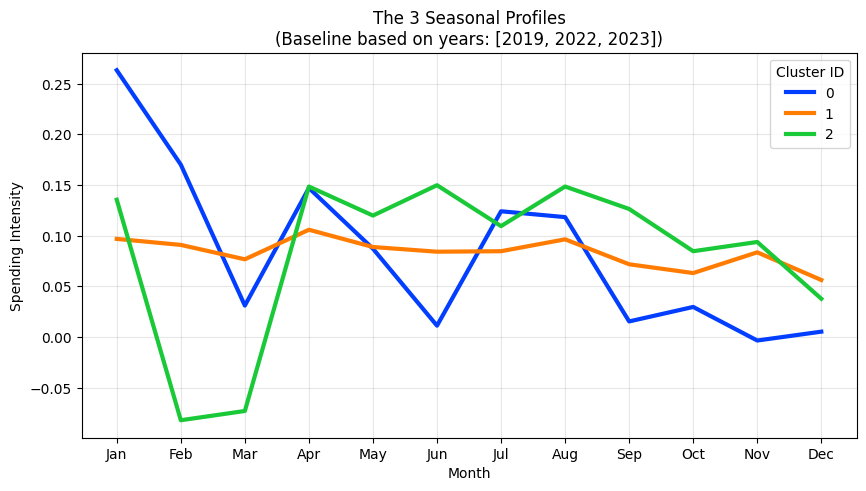

In [ ]:


# Train the cluster k-means model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_stable)

# Assign the cluster labels back to the stable dataset for plotting
X_stable['Cluster'] = kmeans.labels_

# Visualize
df_plot = X_stable.reset_index().melt(id_vars=['State', 'Cluster'], 
                                      var_name='Month', value_name='Seasonal_Index')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x='Month', y='Seasonal_Index', hue='Cluster', 
             palette='bright', linewidth=3, errorbar=None)

plt.title(f'The 3 Seasonal Profiles\n(Baseline based on years: {stable_years})')
plt.ylabel('Spending Intensity')
plt.xlabel('Month')
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
if 'Period' in df_sales.columns:
    df_sales = df_sales.drop(columns='Period')

df_melted = df_sales.melt(id_vars=['observation_date'], var_name='State', value_name='Pct_Change')
df_melted['observation_date'] = pd.to_datetime(df_melted['observation_date'])
df_melted['Month'] = df_melted['observation_date'].dt.month

# Helper to get Matrix
def get_matrix(df, year):
    # Filter by year
    d = df[df['observation_date'].dt.year == year]
    # Pivot
    return d.pivot_table(index='State', columns='Month', values='Pct_Change', aggfunc='mean').fillna(0)

X_2019 = get_matrix(df_melted, 2019)
X_2024 = get_matrix(df_melted, 2024)

# Calculate Metrics
# Ensure states exist in both years
common = X_2019.index.intersection(X_2024.index)
X_2019, X_2024 = X_2019.loc[common], X_2024.loc[common]

# Calculate Pattern Shift (Euclidean Distance on Raw % Data)
# Did the ups and downs happen in different months?
shift_magnitude = np.linalg.norm(X_2019.values - X_2024.values, axis=1)

# Calculate 2024 Performance (Average Growth Rate)
# Is the state generally growing or shrinking in 2024?
avg_growth_2019 = X_2019.mean(axis=1)
avg_growth_2024 = X_2024.mean(axis=1) 

# Combine & Categorize
analysis = pd.DataFrame({
    'State': common,
    'Shift_Magnitude': shift_magnitude,
    'Avg_2019_Growth': avg_growth_2019.values,
    'Avg_2024_Growth': avg_growth_2024.values
})

def categorize(row):
    if row['Avg_2024_Growth'] > row['Avg_2019_Growth']:
        return "New Normal (Growth)" 
    else:
        return "Struggling (Decline)"

analysis['Category'] = analysis.apply(categorize, axis=1)

# Filter for Shifter
non_recovered = analysis[(analysis['Shift_Magnitude'] > 5.0) & analysis['Category']].sort_values('Avg_2024_Growth')

print(f"States with Changed Patterns: {len(non_recovered)}")
print(non_recovered.head())

States with Changed Patterns: 50
   State  Shift_Magnitude  Avg_2019_Growth  Avg_2024_Growth  \
22    MN        17.460813         2.458333        -0.191667   
16    KY        13.723702         1.316667        -0.100000   
14    IN        19.037594         4.066667         0.275000   
48    WV        24.879108         3.850000         0.308333   
17    LA        20.015244         5.191667         0.333333   

                Category  
22  Struggling (Decline)  
16  Struggling (Decline)  
14  Struggling (Decline)  
48  Struggling (Decline)  
17  Struggling (Decline)  
